In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

import warnings
warnings.filterwarnings('ignore')


#I. SMS Phishing Detection
##1. Data Loading


In [ ]:
sdf1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/phishing_dataset/sms_dataset/spam.csv", encoding='ISO-8859-1')

sdf1.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
sdf1.shape

(5572, 5)

In [ ]:
sdf2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/phishing_dataset/sms_dataset/spam_ham_dataset.csv")

sdf2.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
sdf2.shape

(5171, 4)

In [ ]:
# Keep only the relevant columns and rename them
sdf1 = sdf1[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})


sdf2 = sdf2[['label', 'text']]

In [ ]:
sdf1.head(5)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
sdf2.head(5)

,label,text
0,ham,Subject: enron methanol ; meter # : 988291\r\n...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [ ]:
# Combine both datasets into a single DataFrame sdf
sdf = pd.concat([sdf1, sdf2], ignore_index=True)

sdf.sample(5)

,label,text
6830,ham,Subject: august 2000 iferc & sds noms .\r\natt...
2004,ham,"Goodmorning, today i am late for &lt;DECIMAL&..."
4078,ham,O i played smash bros &lt;#&gt; religiously.
8581,ham,Subject: re : path manager rewrite / optimizat...
1,ham,Ok lar... Joking wif u oni...


In [ ]:
sdf['label'] = sdf['label'].apply(lambda x: 1 if x == 'spam' else 0)

sdf.sample(5)

,label,text
5205,1,Had your mobile 11mths ? Update for FREE to Or...
1427,0,THING R GOOD THANX GOT EXAMS IN MARCH IVE DONE...
2936,0,Lol yep did that yesterday. Already got my fir...
8406,0,Subject: re : industrials\r\nif it is the one ...
6368,1,Subject: impress her with a hard erection . . ...


##2. Data Cleaning

In [ ]:
sdf.isnull().sum()

,0
label,0
text,0


In [ ]:
sdf = sdf.dropna()
print(sdf.isna().sum())

label    0
text     0
dtype: int64


In [ ]:
sdf.duplicated().sum()

581

In [ ]:
sdf = sdf.drop_duplicates(keep='first')
sdf.duplicated().sum()

0

In [ ]:
sdf.shape

(10162, 2)

In [ ]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10162 entries, 0 to 10742
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10162 non-null  int64 
 1   text    10162 non-null  object
dtypes: int64(1), object(1)
memory usage: 238.2+ KB


##3. EDA

In [ ]:
sms_type_counts = sdf['label'].value_counts()

print(sms_type_counts)

label
0    8047
1    2115
Name: count, dtype: int64


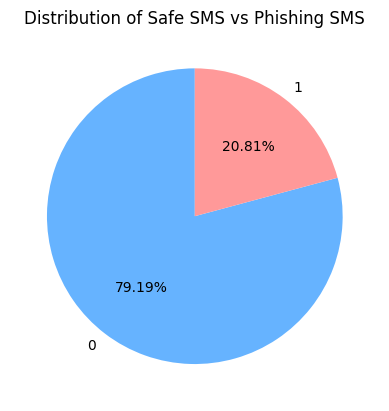

In [ ]:
plt.pie(sms_type_counts, labels=sms_type_counts.index, autopct='%0.2f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Distribution of Safe SMS vs Phishing SMS')
plt.show()

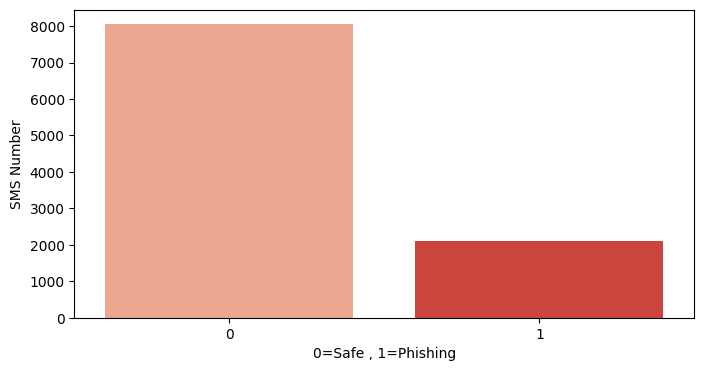

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=sdf, x='label', palette='Reds')
plt.xlabel("0=Safe , 1=Phishing")
plt.ylabel("SMS Number")
plt.show()

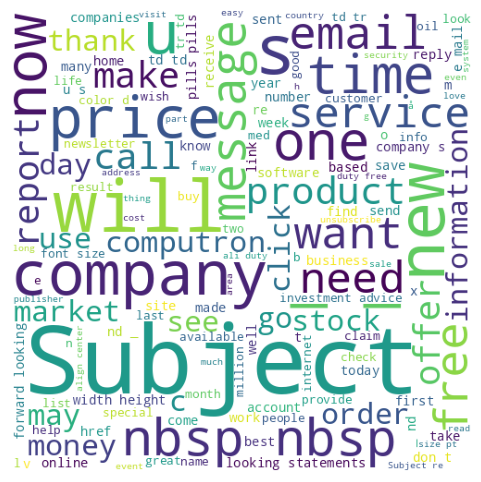

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
phishing_worldcloud = wc.generate(" ".join(sdf[sdf['label'] == 1]['text']))

plt.figure(figsize=(15, 6))
plt.imshow(phishing_worldcloud)
plt.axis('off')
plt.show()

##4.Data Preprocessing

In [ ]:
import string
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

ps = PorterStemmer()

def cleaned_data(text):
    # Convert to lowercase
    text = text.lower()

    # Remove non-alphanumeric characters except letters and numbers
    text = re.sub('[^a-zA-Z0-9]', ' ', text)

    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)

    # Tokenize the cleaned text
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():  # Keep only alphanumeric tokens
            y.append(i)

    text = y[:]
    y.clear()

    # Remove stopwords and punctuation
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
cleaned_text = cleaned_data("Hello! Visit https://example.com for 50% OFF on your purchase!!! Don't miss out. Call us NOW at 123-456-7890 or email at sales@example.com.")
print(cleaned_text)

hello visit exampl com 50 purchas miss call us 123 456 7890 email sale exampl com


In [ ]:
sdf['cleaned_text'] = sdf['text'].apply(cleaned_data)

In [ ]:
sdf.sample(5)

,label,text,cleaned_text
6248,1,Subject: use the links to get more information...,subject use link get inform rx meed deliv spee...
1034,0,ZOE IT JUST HIT ME 2 IM FUCKING SHITIN MYSELF ...,zoe hit 2 im fuck shitin il defo tri hardest 2...
4660,0,Ok no prob...,ok prob
3710,0,"Sorry pa, i dont knw who ru pa?",sorri pa dont knw ru pa
10700,0,Subject: hplc / tglo deals\r\ndarren :\r\ni ha...,subject hplc tglo deal darren request jim coff...


In [ ]:
sdf = sdf[['label', 'cleaned_text']]
sdf.sample(5)

,label,cleaned_text
2259,0,ill call even ill idea
9091,0,subject fw payment jo hillier smith owner care...
5743,0,subject e mail list class pleas respond great ...
3741,0,hey bore think u wat r u
3068,0,ay wana meet sat wkg sat


In [ ]:
sdf = sdf.drop_duplicates(keep='first')
sdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9989 entries, 0 to 10742
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label         9989 non-null   int64 
 1   cleaned_text  9989 non-null   object
dtypes: int64(1), object(1)
memory usage: 234.1+ KB


In [ ]:
sdf.sample(5)

,label,cleaned_text
6971,0,subject input spot deal system ad sitara ticke...
9478,1,subject new zenoil massiv rock sloid erect 60 ...
2009,0,keep go never intent run choos rather keep roo...
3492,0,cool text head
2553,0,give time walk


In [ ]:
# now counting the top words used in smishing
from collections import Counter
phishing = []
for msg in sdf[sdf['label'] == 1]['cleaned_text'].tolist():
    for word in msg.split():
        phishing.append(word)

Counter(phishing).most_common(10)

[('subject', 1618),
 ('3', 1258),
 ('com', 1036),
 ('2', 1028),
 ('http', 1000),
 ('compani', 921),
 ('1', 792),
 ('price', 745),
 ('0', 682),
 ('www', 665)]

##5.Feature Etraction

In [ ]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=5000)

In [ ]:
sdf = sdf.dropna(subset=['cleaned_text'])
X = tfidf.fit_transform(sdf['cleaned_text']).toarray()
X.shape

(9989, 5000)

In [ ]:
print("Total features:", len(tfidf.get_feature_names_out()))

Total features: 5000


In [ ]:
non_zero_indices = np.nonzero(X[0])[0]  # non-zero indices for the document
non_zero_words = tfidf.get_feature_names_out()[non_zero_indices]  # corresponding words
non_zero_tfidf_scores = X[0, non_zero_indices]  # TF-IDF scores for non-zero words


for word, score in zip(non_zero_words, non_zero_tfidf_scores):
    print(f"Word: {word}, TF-IDF Score: {score}")

Word: amor, TF-IDF Score: 0.4957742344761679
Word: avail, TF-IDF Score: 0.24402683569030387
Word: crazi, TF-IDF Score: 0.40073100353120233
Word: go, TF-IDF Score: 0.19501413330056974
Word: got, TF-IDF Score: 0.2471844053064956
Word: great, TF-IDF Score: 0.26129825658480105
Word: la, TF-IDF Score: 0.3373972970559402
Word: point, TF-IDF Score: 0.26090474772581745
Word: wat, TF-IDF Score: 0.320812763892794
Word: world, TF-IDF Score: 0.2860716701639775


In [ ]:
y = sdf['label'].values

##6.Model Training

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [ ]:
print(X_train.shape, X_test.shape)

(7991, 5000) (1998, 5000)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score

# Khởi tạo mô hình DecisionTree với tham số mặc định
dt = DecisionTreeClassifier(random_state=42)

# Huấn luyện mô hình
dt.fit(X_train, y_train)

# Dự đoán từ mô hình đã huấn luyện
y_pred = dt.predict(X_test)

# Đánh giá mô hình
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Precision (weighted):", precision_score(y_test, y_pred, average='weighted'))
print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))


Accuracy: 0.9309309309309309
Confusion Matrix:
 [[1506   81]
 [  57  354]]
Precision (weighted): 0.9327295923893977
F1 Score (weighted): 0.9316475137751733


In [ ]:
from joblib import dump
import os

# Đảm bảo đường dẫn tới thư mục là chính xác
drive_path = '/content/drive/MyDrive/Colab Notebooks/phishing_dataset/sms_dataset'

# Lưu vectorizer (tfidf) và mô hình (rf)
dump(tfidf, os.path.join(drive_path, 'vectorizer_DecisionTree.pkl'))
dump(dt, os.path.join(drive_path, 'model_DecisionTree.pkl'))


['/content/drive/MyDrive/Colab Notebooks/phishing_dataset/sms_dataset/model_DecisionTree.pkl']

##7.Inference

In [ ]:
from joblib import load
import numpy as np

loaded_model = load("/content/drive/MyDrive/Colab Notebooks/phishing_dataset/sms_dataset/model_DecisionTree.pkl")
loaded_vectorizer = load("/content/drive/MyDrive/Colab Notebooks/phishing_dataset/sms_dataset/vectorizer_DecisionTree.pkl")

# Example input
input_messages = np.array([
    "Congratulations! You've been selected for a free vacation to the Bahamas. Click to claim your prize.",
    "Please check the attached report for the meeting tomorrow.",
    "Free entry into our contest to win a brand new car! Click here now.",
    "Meeting scheduled for 10 AM. Don’t forget the necessary documents.",
])

# Vectorize the input messages using the loaded vectorizer

vectorized_messages = loaded_vectorizer.transform(input_messages)
print(vectorized_messages.shape)
predictions = loaded_model.predict(vectorized_messages)
print(predictions)

(4, 5000)
[1 0 1 0]
